In [1]:
import sys
import time

import cv2
import numpy as np

from dynaphos.image_processing import sobel_processor, canny_processor
from dynaphos.simulator import GaussianSimulator
from dynaphos.utils import load_params, load_coordinates_from_yaml, Map
from dynaphos.cortex_models import \
    get_visual_field_coordinates_from_cortex_full

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
params = load_params('../dynaphos-core/config/params.yaml')

In [3]:
params['thresholding']['use_threshold'] = False
coordinates_cortex = load_coordinates_from_yaml(
    '../dynaphos-core/config/grid_coords_dipole_valid.yaml', n_coordinates=1000)
coordinates_cortex = Map(*coordinates_cortex)
coordinates_visual_field = get_visual_field_coordinates_from_cortex_full(
    params['cortex_model'], coordinates_cortex)
simulator = GaussianSimulator(params, coordinates_visual_field)
resolution = params['run']['resolution']
fps = params['run']['fps']

In [4]:
import scipy.io

subject = 'hp'
image_id = 'i05june05_static_street_boston_p1010764'#'i1485351340'

image = cv2.imread(f'../../EyetrackingDatabaseFolder/ALLSTIMULI/{image_id}.jpeg') 
mat = scipy.io.loadmat(f'../../EyetrackingDataBaseFolder/DATA/{subject}/{image_id}.mat')
eye_data = mat[image_id]['DATA'][0][0][0][0][2]

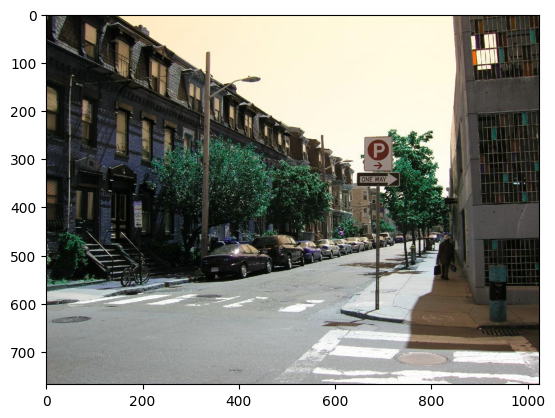

In [5]:
fig, axs = plt.subplots()
# axs.axis('off')
axs.imshow(image)

1024 768
(688, 2)


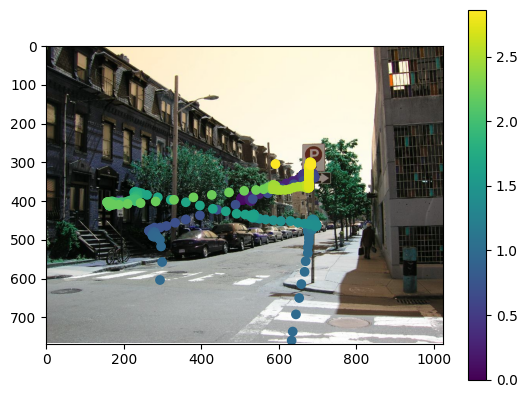

In [6]:
y_res, x_res = image.shape[:2]
print(x_res, y_res)

eye_data = eye_data[(eye_data[:,0]>=0) & (eye_data[:,0]<x_res) & (eye_data[:,1]>=0) & (eye_data[:,1]<y_res)]
print(eye_data.shape)
plt.figure()

implot = plt.imshow(image)
plt.scatter(eye_data[:,0],eye_data[:,1], c=np.arange(eye_data.shape[0])/240)
plt.colorbar()
plt.show()

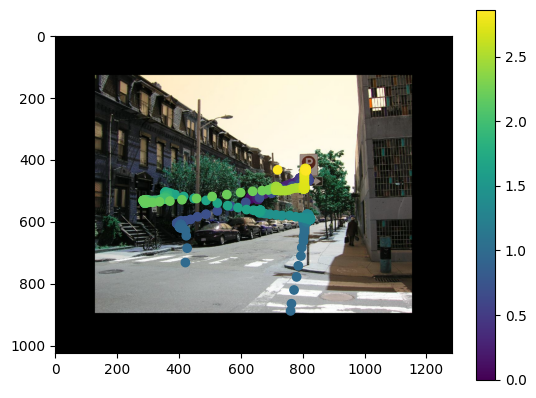

In [7]:
x_offset = resolution[0]//2
y_offset = resolution[1]//2

image_sub = np.zeros((image.shape[0]+resolution[0]+2,image.shape[1]+resolution[1]+2,3), dtype=int)
image_sub[x_offset+1:-x_offset-1, y_offset+1:-y_offset-1] = image

eye_data_sub = eye_data.copy()
eye_data_sub[:,0] += x_offset
eye_data_sub[:,1] += y_offset

implot = plt.imshow(image_sub)
plt.scatter(eye_data_sub[:,0],eye_data_sub[:,1], c=np.arange(eye_data.shape[0])/240)
plt.colorbar()
plt.show()

In [8]:
n_frames = len(eye_data)
frames = np.zeros((n_frames,resolution[0],resolution[1],3), dtype=np.float32)

for i in tqdm(range(n_frames)):
    x_offset = resolution[0]//2
    y_offset = resolution[1]//2
    pos = eye_data_sub[i].astype(int)
    frames[i] = image_sub[pos[0] - x_offset:pos[0] + x_offset, pos[1] - y_offset:pos[1] + y_offset]
    frames[i] = frames[i]/255

100%|██████████████████████████████████████████████████████████████████████████████| 688/688 [00:00<00:00, 4546.50it/s]


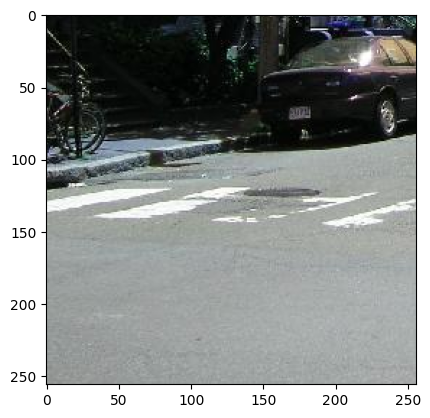

In [9]:
plt.imshow(frames[-1])

In [16]:
sim_frames = np.zeros((n_frames,resolution[0],resolution[1]))
for i, frame in enumerate(frames):
    frame = cv2.resize(frame, resolution)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame, (3, 3), 0)
    
    method = params['sampling']['filter']
    if method == 'sobel':
        processed_img = sobel_processor(frame)
    elif method == 'canny':
        threshold = params['sampling']['T_high']
        processed_img = canny_processor(frame, threshold // 2,
                                        threshold)
    elif method == 'none':
        processed_img = frame
    else:
        raise ValueError(f"{method} is not a valid filter keyword.")

    # Generate phosphenes
    stim_pattern = simulator.sample_stimulus(processed_img)
    stim_pattern = stim_pattern*10000
    #print(stim_pattern)
    phosphenes = simulator(stim_pattern)
    phosphenes = phosphenes.cpu().numpy() * 255
    
    sim_frames[i] = phosphenes

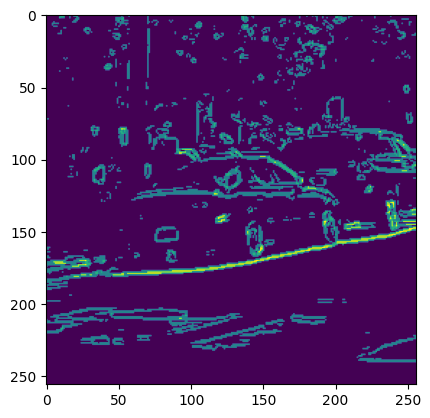

In [11]:
plt.imshow(processed_img)

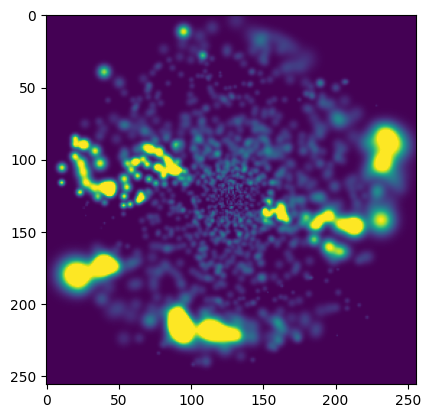

In [17]:
plt.imshow(sim_frames[0])

In [31]:
sim_vid_sub = np.zeros((n_frames,image_sub.shape[0],image_sub.shape[1]))

for i in tqdm(range(n_frames)):
    pos = eye_data_sub[i].astype(int)
    sim_vid_sub[i,pos[0] - x_offset:pos[0] + x_offset, pos[1] - y_offset:pos[1] + y_offset] = sim_frames[i]
    
#remove border
sim_vid = sim_vid_sub#[:,x_offset+1:-x_offset-1, y_offset+1:-y_offset-1]

100%|██████████████████████████████████████████████████████████████████████████████| 688/688 [00:00<00:00, 2359.60it/s]


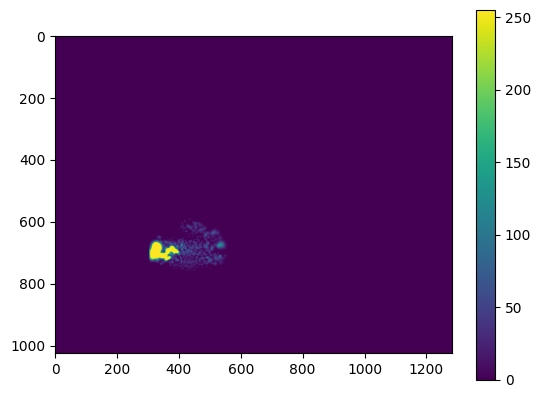

In [32]:
plt.imshow(sim_vid[-1])
plt.scatter(eye
plt.colorbar()

In [28]:
#write to video

size = y_res, x_res
# duration = 2
fps = 25
out = cv2.VideoWriter(f'eye_tracked_{image_id}_subject_{subject}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), False)
for i in range(n_frames):
    data = sim_vid[i].astype('uint8') #np.random.randint(0, 256, size, dtype='uint8')
    out.write(data)
out.release()

In [ ]:

def main(params: dict, in_video: int):
    params['thresholding']['use_threshold'] = False
    coordinates_cortex = load_coordinates_from_yaml(
        '../config/grid_coords_dipole_valid.yaml', n_coordinates=100)
    coordinates_cortex = Map(*coordinates_cortex)
    coordinates_visual_field = get_visual_field_coordinates_from_cortex_full(
        params['cortex_model'], coordinates_cortex)
    simulator = GaussianSimulator(params, coordinates_visual_field)
    resolution = params['run']['resolution']
    fps = params['run']['fps']

    prev = 0
    cap = cv2.VideoCapture(in_video)
    ret, frame = cap.read()
    while ret:

        # Capture the video frame by frame
        ret, frame = cap.read()

        time_elapsed = time.time() - prev
        if time_elapsed > 1 / fps:
            prev = time.time()

            # Create Canny edge detection mask
            frame = cv2.resize(frame, resolution)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.GaussianBlur(frame, (3, 3), 0)

            method = params['sampling']['filter']
            if method == 'sobel':
                processed_img = sobel_processor(frame)
            elif method == 'canny':
                threshold = params['sampling']['T_high']
                processed_img = canny_processor(frame, threshold // 2,
                                                threshold)
            elif method == 'none':
                processed_img = frame
            else:
                raise ValueError(f"{method} is not a valid filter keyword.")

            # Generate phosphenes
            stim_pattern = simulator.sample_stimulus(processed_img)
            phosphenes = simulator(stim_pattern)
            phosphenes = phosphenes.cpu().numpy() * 255

            # Concatenate results
            cat = np.concatenate([frame, processed_img, phosphenes],
                                 axis=1).astype('uint8')

            # Display the resulting frame
            cv2.imshow('Simulator', cat)

        # the 'q' button is set as the quit button
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    # Destroy all the windows
    cv2.destroyAllWindows()


if __name__ == '__main__':
    _params = load_params('../config/params.yaml')
    _in_video = r"C:\Users\grinten\Documents\Simulator\dynaphos-experiments\dynaphos-core\examples\example_video.mp4"  # use 0 for webcam, or string with video path
    main(_params, _in_video)
    sys.exit()